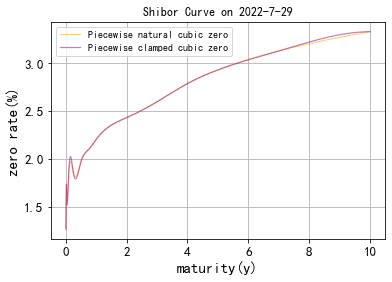

In [2]:
# 2022.7.29
'''
IRS-Shibor3M contract details：
· 交易方式：T+1（如2018.1.25-2018.4.24的浮动利率水平在2018.1.24确定）
· 支付日调整：经调整的下一营业日
· 支付周期：3M
· 计息基准：fixed leg actual/365（单利），floating leg actual/360（单利）

今天是2022.7.29，对于构成今天swap rate curve的irs，其起息日为2022.7.30，
'''
import warnings
warnings.filterwarnings('ignore')
import QuantLib as ql
from pandas import DataFrame
import pandas as pd
import numpy as np
from math import pow
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt

today = ql.Date(29,7,2022)
china_calendar = ql.China()


### step1: get raw data ###

def get_shibor_data():
    '''
    terms: o/n, 1w, 2w, 1m, 3m
    :return:
    '''
    path = r'E:\实习\微京科技\数据\220720历史数据\processed\SHIBOR（Wind-全国银行间同业拆借中心）.csv'
    data = pd.read_csv(path, header=0, index_col='Date')
    newest_data = list(data.iloc[-1])
    res = newest_data[0:5]
    return res

def get_irs_data():
    '''
    tenors: 6m, 9m, 1y, 2y, 3y, 4y, 5y, 7y, 10y
    :return: a list of the latest irs rates
    '''
    path = r'E:\实习\微京科技\数据\220720历史数据\processed\SHIBOR3M IRS（Wind-中国货币网）.csv'
    data = pd.read_csv(path, header=0, index_col='Date')
    newest_data = list(data.iloc[-1])
    return newest_data


### step2: integrate the data ###

def get_integrated_data():
    # step01 确定interest_col和term_col
    sh_rates = get_shibor_data()
    irs_rates = get_irs_data()
    rates = sh_rates + irs_rates
    terms = ['O/N', '1W', '2W', '1M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y']
    d = dict(zip(terms, rates))

    term1 = ['O/N', '1W', '2W', '1M', '3M', '6M', '9M', '1Y']
    term2 = [ str(i)+'M' if i%12 != 0 else str(int(i/12)) + 'Y' for i in range(15,121,3) ]
    term_col = term1 + term2

    interest_col = []
    for key in term_col:
        if key in terms:
            interest_col.append(d[key])
        else:
            interest_col.append(np.nan)

    # step02 确定start_date_col和end_date_col
    tom = today + 1
    start_date_1 = "%d-%d-%d" % (today.year(), today.month(), today.dayOfMonth())
    start_date_2 = "%d-%d-%d" % (tom.year(), tom.month(), tom.dayOfMonth())
    start_date_col = [start_date_1] + [start_date_2]*(len(term_col) - 1)

    end_date_col = []
    end_date_col.append(start_date_2)
    tmp = [today + ql.Period(ql.Weekly), today + ql.Period(ql.Weekly)*2, today + ql.Period(ql.Monthly), today + ql.Period(ql.Quarterly)]
    for i in range(2,41):
        d = today + ql.Period(ql.Quarterly)*i
        tmp.append(d)

    for date in tmp:
        date_str = "%d-%d-%d" % (date.year(), date.month(), date.dayOfMonth())
        end_date_col.append(date_str)

    # step03 整合成dataframe
    df = DataFrame(
        dict(
            start_date = start_date_col,
            end_date = end_date_col,
            term = term_col,
            interest = interest_col
        )
    )
    df['start_date'] = pd.to_datetime(df['start_date'], format = '%Y-%m-%d')
    df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')

    return  df


### step3: get spot rate and DF ###

data = get_integrated_data()

def spotrateDF(method, data):
    '''
    该函数通过bootstrap和interpolation得出spot_rate和DF两个list
    method:为了补全irs的incomplete information而采用的interpolation method
    '''
    t = np.array((data.end_date - data.start_date).dt.days / 365)  # t是maturity array

    # step01 求o/n, 1w, 2w, 1m, 3m期限的DF(t)及spot_rate(t)
    DF = np.array(1 / (1 + data.interest / 100 * (data.end_date - data.start_date).dt.days / 360))
    spot_rate = -np.log(DF) / t

    add = np.zeros(len(t))  # 设置辅助列add
    M_3 = data[data.term == '3M'].index.tolist()  # 查询期限为3M的行序号  得到M_3 = [4]

    add[M_3] = t[M_3] * DF[M_3]  # 从第3个月起后续需要进行剥靴处理，增加辅助列
    i = M_3[0] + 1    # i=5（对应6m）
    Y_1 = data[data.term == '1Y'].index.tolist()  # 查询期限为1Y的行序号


    # step02 求6m, 9m, 1y期限的DF(t)及spot_rate(t)
    while (i < Y_1[0] + 1):  # 当行号i对应的term为6m, 9m, 1y
        DF[i] = (1 - data.interest[i] / 100 * add[i - 1]) / (1 + data.interest[i] / 100 * (data.end_date[i] - data.end_date[i - 1]).days / 365)    # 更新DF中6m, 9m, 1y期限的value
        add[i] = (data.end_date[i] - data.end_date[i - 1]).days / 365 * DF[i] + add[i - 1]
        i = i + 1
    spot_rate = -np.log(DF) / t  # 根据更新后的DF，重新计算1y及以内的spot rate


    # step03 处理15m, 18m, 21m, 2y, 27m, ...
    # 寻找interest列的所有的NaN的索引，存入loc列表
    for columname in data.columns:
        if data[columname].count() != len(data):
            loc = data[columname][data[columname].isnull().values == True].index.tolist()

    c = []
    for i in range(len(loc) - 1):
        if (loc[i + 1] - loc[i]) != 1:  # 有两个不相邻的NaN，如index为14，16
            c.append(loc[i + 1])  # c中添加index 16

    c.append(len(data.index.tolist()))  # 得到需要插值的即期利率索引 c=[12, 16, 20, 24, 32, 44]


    # 求spot rate curve>1y部分，采用Piecewise Linear/Piecewise Log Linear/Cubic Spline/Hermite/Monotone convex方法确定关键期限点之间的spot rate，然后进行bootstrap
    def get_spot_rate(start, end):
        import scipy.optimize as so
        def f(y):   # y is the assumed spot rate of term [end], and f(y) returns the present value of the IRS's fixed leg with tenor [end]
            i = start + 1
            while (i <= end):
                if method == 1:  # Piecewise Linear zero
                    spot_rate[i] = spot_rate[start] + (data.end_date[i] - data.end_date[start]) / (data.end_date[end] - data.end_date[start]) * (y - spot_rate[start])
                if method == 2:  # Piecewise Log Linear zero
                    spot_rate[i] = np.exp( np.log(spot_rate[start]) + (data.end_date[i] - data.end_date[start]) / (data.end_date[end] - data.end_date[start]) * (np.log(y) - np.log(spot_rate[start])) )
                if method == 3:  # natural Cubic Spline
                    from scipy.interpolate import CubicSpline
                    mat = list(np.array((data.end_date - data.start_date).dt.days / 365))
                    xs = np.array([ mat[i] for i in range(0,start-1) ] + [mat[end-1]])
                    ys = np.array([ spot_rate[i] for i in range(0,start-1) ] + [y])
                    f = CubicSpline(xs,ys,bc_type='natural')
                    spot_rate[i] = f(mat[i])
                if method == 4:  # clamped Cubic Spline
                    from scipy.interpolate import CubicSpline
                    mat = list(np.array((data.end_date - data.start_date).dt.days / 365))
                    xs = np.array([ mat[i] for i in range(0,start-1) ] + [mat[end-1]])
                    ys = np.array([ spot_rate[i] for i in range(0,start-1) ] + [y])
                    f = CubicSpline(xs,ys,bc_type='clamped')
                    spot_rate[i] = f(mat[i])

                add[i] = (data.end_date[i] - data.end_date[i - 1]).days / 365 * DF[i] + add[i - 1]
                i = i + 1

            DF[start + 1:end] = np.exp(-t[start + 1:end] * spot_rate[start + 1:end])
            DF[end] = np.exp(-t[end] * y)
            return 100 * data.interest[end] / 100 * add[end] + 100 * DF[end] - 100

        return so.fsolve(f, 0.01)    # returns the value of y

    # 调用get_spot_rate，更新spot_rate list的后半部分
    spot_rate[c[0] - 1] = get_spot_rate(loc[0] - 1, c[0] - 1)   # 2y的spot rate = get_spot_rate(1y, 2y)
    i = 1

    while (i < len(c)):
        spot_rate[c[i] - 1] = get_spot_rate(c[i - 1] - 1, c[i] - 1)
        i = i + 1

    # 调整交易由于是T+1，统一贴现至估值日即即期利率与贴现因子（T+0交易无需该步骤）
    DF1 = DF * DF[0]
    DF1[0] = DF[0]
    DF = DF1
    t1 = np.array((data.end_date - data.start_date[0]).dt.days / 365)
    i = 0
    while (i < len(t1)):
        spot_rate[i] = -np.log(DF[i]) / t1[i]
        i = i + 1
    return spot_rate, DF


### step3.5: generate the curve function ###

def curve_func(method, source, maturity, t):
    '''
    该函数用于根据自变量maturity和因变量source，按照method指定的interpolation方法，生成spot rate function f(t)或者DF function f(t)
    method:得到所有结果后构建曲线的interpolation method，与spotrateDF()的method应保持一致
    source:可以是zero rate or DF
    '''
    if method == 1 or method==2:
        i=0
        while i <= len(source)-2:
            if t == maturity[-1]:
                return source[-1]
            elif t >= maturity[i] and t < maturity[i+1]:
                def piecewise(term):
                    if method == 1:
                        res = (t - maturity[i])*source[i+1]/(maturity[i+1] - maturity[i]) + (maturity[i+1] - t)*source[i]/(maturity[i+1] - maturity[i])
                    if method == 2:
                        res = pow(source[i], (maturity[i + 1] - term) / (maturity[i + 1] - maturity[i])) * \
                                 pow(source[i + 1], (term - maturity[i]) / (maturity[i + 1] - maturity[i]))
                    return res
                return piecewise(t)
            else:
                i+=1
    elif method == 3:
        from scipy.interpolate import CubicSpline
        index = data['interest'][data['interest'].isnull().values == False].index.tolist()
        f = CubicSpline([maturity[i] for i in index], [source[i] for i in index], bc_type='natural')
        return f(t)
    else:
        from scipy.interpolate import CubicSpline
        index = data['interest'][data['interest'].isnull().values == False].index.tolist()
        f = CubicSpline([maturity[i] for i in index], [source[i] for i in index], bc_type='clamped')
        return f(t)



### step4: visualize the results ###

def visualization(data):
    '''return the results of spot rate and discount factor'''

    spot_rate_1 = spotrateDF(1, data)[0]
    DF_1 = spotrateDF(1, data)[1]
    spot_rate_2 = spotrateDF(2, data)[0]
    DF_2 = spotrateDF(2, data)[1]
    spot_rate_3 = spotrateDF(3, data)[0]
    DF_3 = spotrateDF(3, data)[1]
    spot_rate_4 = spotrateDF(4, data)[0]
    DF_4 = spotrateDF(4, data)[1]
        
    mpl.rcParams['font.sans-serif']=['SimHei']
    mpl.rcParams['axes.unicode_minus']=False

    mat = list(np.array((data.end_date - data.start_date).dt.days / 365))
    methods = {
        1:'Piecewise linear zero',
        2:'Piecewise log linear zero',
        3:'Piecewise natural cubic zero',
        4:'Piecewise clamped cubic zero'
    }

    plt.figure(figsize=(6,4))
    plt.plot(np.linspace(mat[0],mat[-1],10000), [curve_func(3, spot_rate_3, mat, t)*100 for t in np.linspace(mat[0],mat[-1],10000)], c='orange', lw=1.2, label=methods[3], alpha=0.5)
    plt.plot(np.linspace(mat[0],mat[-1],10000), [curve_func(4, spot_rate_4, mat, t)*100 for t in np.linspace(mat[0],mat[-1],10000)], c='purple', lw=1.2, label=methods[4], alpha=0.5)
    plt.xlabel(u'maturity(y)',fontsize=15)
    plt.xticks(fontsize=13)
    plt.ylabel(u'zero rate(%)',fontsize=15)
    plt.yticks(fontsize=13)
    plt.title('Shibor Curve on %d-%d-%d' % (today.year(), today.month(), today.dayOfMonth()))
    plt.legend(loc=0)
    plt.grid('True')
    plt.show()

Visualized=visualization(data)